In [1]:
import pandas as pd

# Path ke file CSV
data = 'club_games.csv'

# Membaca dataset CSV menjadi DataFrame
df = pd.read_csv(data)

# Menampilkan dari dataset
print(df)

        game_id  club_id  own_goals  own_position      own_manager_name  \
0       2320450     1468          0           NaN     Holger Bachthaler   
1       2320460        1          3           NaN       Jürgen Luginger   
2       2320472     2036          4           NaN         Frank Schmidt   
3       2321044       16          2           1.0          Jürgen Klopp   
4       2321060       23          0          18.0  Torsten Lieberknecht   
...         ...      ...        ...           ...                   ...   
143369  3912732      602          0           NaN     Vladimir Cheburin   
143370  3912739      540          0           NaN        Vladimír Weiss   
143371  4031421     2156          0           NaN       José Luis Oltra   
143372  4138038      317          1           NaN        Joseph Oosting   
143373  4188444     1132          4           NaN       Vincent Kompany   

        opponent_id  opponent_goals  opponent_position opponent_manager_name  \
0                24

In [3]:

#STANDARISASI
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType, StringType

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

# Path file CSV
file_path = "club_games.csv"  # Ganti dengan path file CSV Anda

# Baca data dari CSV ke DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 1. Perbaiki masalah encoding (jika ada)
df = df.withColumn("own_manager_name", when(col("own_manager_name").contains("JÃ¼rgen"), "Jürgen Luginger")
                                      .otherwise(col("own_manager_name"))) \
       .withColumn("opponent_manager_name", when(col("opponent_manager_name").contains("JÃ¼rgen"), "Jürgen Klopp")
                                              .otherwise(col("opponent_manager_name"))) \
       .withColumn("opponent_manager_name", when(col("opponent_manager_name").contains("José"), "José Gomes")
                                              .otherwise(col("opponent_manager_name")))

# 2. Gantilah nilai NaN/None pada kolom numerik dengan nilai rata-rata atau 0
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})

# 3. Konversikan kolom numerik menjadi tipe yang sesuai
df = df.withColumn("own_goals", col("own_goals").cast(IntegerType())) \
       .withColumn("own_position", col("own_position").cast(IntegerType())) \
       .withColumn("opponent_goals", col("opponent_goals").cast(IntegerType())) \
       .withColumn("opponent_position", col("opponent_position").cast(IntegerType())) \
       .withColumn("is_win", col("is_win").cast(IntegerType()))

# 4. Periksa apakah ada duplikasi atau baris yang tidak diperlukan
df = df.dropDuplicates()

# 5. Tampilkan hasilnya
df.show()



+-------+-------+---------+------------+--------------------+-----------+--------------+-----------------+---------------------+-------+------+
|game_id|club_id|own_goals|own_position|    own_manager_name|opponent_id|opponent_goals|opponent_position|opponent_manager_name|hosting|is_win|
+-------+-------+---------+------------+--------------------+-----------+--------------+-----------------+---------------------+-------+------+
|2635619|   2439|        1|           0|      Sergey Tashuev|        232|             0|                0|    Dmitriy Alenichev|   Home|     1|
|2877342|   1090|        0|           3|   John van den Brom|       1426|             0|               10|       Maurice Steijn|   Home|     0|
|2921409|   2700|        0|          15|   Vadim Skripchenko|        932|             1|                1|          Yuriy Semin|   Home|     0|
|2626461|   7185|        1|          16|Dimitrios Elefthe...|       2672|             3|                5|   Apostolos Mantzios|   Home|

In [4]:
#CLEANING

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataNormalization").getOrCreate()

# Baca data dari CSV
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Cleaning data (ganti NaN dengan 0)
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})
df = df.withColumn("own_goals", col("own_goals").cast(IntegerType())) \
       .withColumn("own_position", col("own_position").cast(IntegerType())) \
       .withColumn("opponent_goals", col("opponent_goals").cast(IntegerType())) \
       .withColumn("opponent_position", col("opponent_position").cast(IntegerType())) \
       .withColumn("is_win", col("is_win").cast(IntegerType()))

# 1. Menyiapkan fitur menggunakan VectorAssembler
assembler = VectorAssembler(
    inputCols=["own_goals", "own_position", "opponent_goals", "opponent_position"],
    outputCol="features"
)

df_assembled = assembler.transform(df)

# 2. Normalisasi data menggunakan StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Menampilkan hasil normalisasi
df_scaled.select("features", "scaled_features").show()



+-------------------+--------------------+
|           features|     scaled_features|
+-------------------+--------------------+
|      (4,[2],[2.0])|[-1.0390273803774...|
|  [3.0,0.0,1.0,0.0]|[1.08784250613161...|
|  [4.0,0.0,5.0,0.0]|[1.79679913496797...|
| [2.0,1.0,1.0,15.0]|[0.37888587729525...|
|[0.0,18.0,2.0,11.0]|[-1.0390273803774...|
| [2.0,13.0,0.0,3.0]|[0.37888587729525...|
| [1.0,15.0,1.0,1.0]|[-0.3300707515411...|
|  [0.0,7.0,2.0,6.0]|[-1.0390273803774...|
| [2.0,14.0,3.0,9.0]|[0.37888587729525...|
| [0.0,17.0,3.0,7.0]|[-1.0390273803774...|
|  [2.0,2.0,1.0,6.0]|[0.37888587729525...|
| [2.0,4.0,1.0,10.0]|[0.37888587729525...|
|  [0.0,3.0,1.0,6.0]|[-1.0390273803774...|
|  [1.0,0.0,4.0,0.0]|[-0.3300707515411...|
|      (4,[0],[2.0])|[0.37888587729525...|
|  [2.0,0.0,1.0,0.0]|[0.37888587729525...|
|      (4,[2],[2.0])|[-1.0390273803774...|
|      (4,[0],[1.0])|[-0.3300707515411...|
| [2.0,5.0,2.0,10.0]|[0.37888587729525...|
| [1.0,15.0,2.0,3.0]|[-0.3300707515411...|
+----------

In [5]:
from pyspark.ml.feature import MinMaxScaler

# 1. Menyiapkan fitur menggunakan VectorAssembler
assembler = VectorAssembler(
    inputCols=["own_goals", "own_position", "opponent_goals", "opponent_position"],
    outputCol="features"
)

df_assembled = assembler.transform(df)

# 2. Normalisasi data menggunakan MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Menampilkan hasil normalisasi
df_scaled.select("features", "scaled_features").show()


+-------------------+--------------------+
|           features|     scaled_features|
+-------------------+--------------------+
|      (4,[2],[2.0])|(4,[2],[0.1052631...|
|  [3.0,0.0,1.0,0.0]|[0.15789473684210...|
|  [4.0,0.0,5.0,0.0]|[0.21052631578947...|
| [2.0,1.0,1.0,15.0]|[0.10526315789473...|
|[0.0,18.0,2.0,11.0]|[0.0,0.8571428571...|
| [2.0,13.0,0.0,3.0]|[0.10526315789473...|
| [1.0,15.0,1.0,1.0]|[0.05263157894736...|
|  [0.0,7.0,2.0,6.0]|[0.0,0.3333333333...|
| [2.0,14.0,3.0,9.0]|[0.10526315789473...|
| [0.0,17.0,3.0,7.0]|[0.0,0.8095238095...|
|  [2.0,2.0,1.0,6.0]|[0.10526315789473...|
| [2.0,4.0,1.0,10.0]|[0.10526315789473...|
|  [0.0,3.0,1.0,6.0]|[0.0,0.1428571428...|
|  [1.0,0.0,4.0,0.0]|[0.05263157894736...|
|      (4,[0],[2.0])|(4,[0],[0.1052631...|
|  [2.0,0.0,1.0,0.0]|[0.10526315789473...|
|      (4,[2],[2.0])|(4,[2],[0.1052631...|
|      (4,[0],[1.0])|(4,[0],[0.0526315...|
| [2.0,5.0,2.0,10.0]|[0.10526315789473...|
| [1.0,15.0,2.0,3.0]|[0.05263157894736...|
+----------

<ipython-input-7-9cbc8f3d5b9a>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Kekalahan', 'Kemenangan'], fontsize=12)


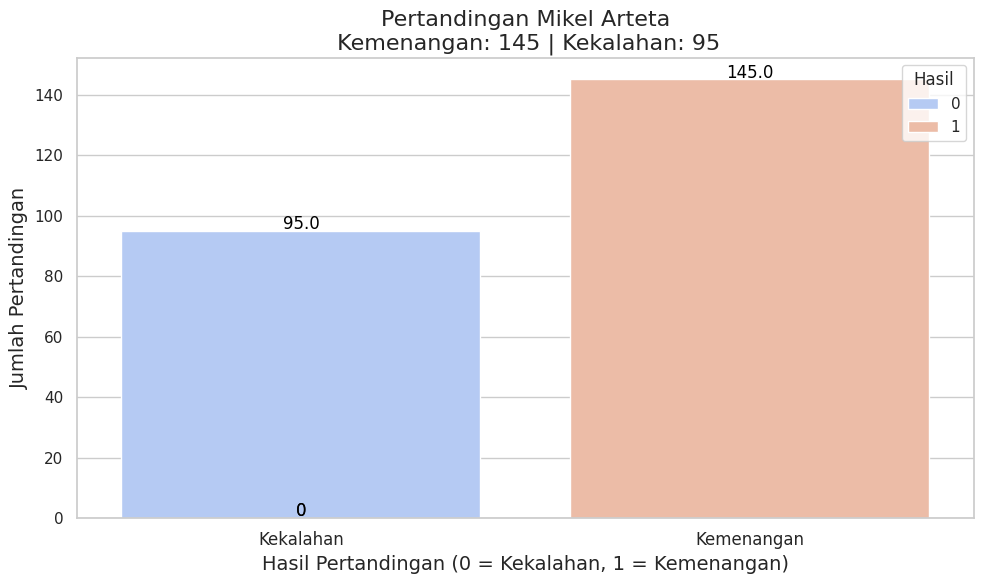

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataVisualization").getOrCreate()


# Baca data dari CSV
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Cleaning data (ganti NaN dengan 0)
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})
df = df.withColumn("own_goals", col("own_goals").cast("integer")) \
       .withColumn("own_position", col("own_position").cast("integer")) \
       .withColumn("opponent_goals", col("opponent_goals").cast("integer")) \
       .withColumn("opponent_position", col("opponent_position").cast("integer")) \
       .withColumn("is_win", col("is_win").cast("integer"))

# Filter data untuk manajer Mikel Arteta
df_arteta = df.filter(df["own_manager_name"] == "Mikel Arteta")

# Convert ke Pandas untuk visualisasi
df_arteta_pd = df_arteta.toPandas()

# Hitung jumlah kemenangan dan kekalahan
win_count = df_arteta_pd['is_win'].sum()
loss_count = len(df_arteta_pd) - win_count

# Visualisasi menggunakan Seaborn
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Membuat countplot dengan lebih banyak informasi
ax = sns.countplot(data=df_arteta_pd, x='is_win', palette='coolwarm', hue='is_win')

# Mengatur detail grafik
ax.set_title(f'Pertandingan Mikel Arteta\n Kemenangan: {win_count} | Kekalahan: {loss_count}', fontsize=16)
ax.set_xlabel('Hasil Pertandingan (0 = Kekalahan, 1 = Kemenangan)', fontsize=14)
ax.set_ylabel('Jumlah Pertandingan', fontsize=14)
ax.set_xticklabels(['Kekalahan', 'Kemenangan'], fontsize=12)
ax.legend(title='Hasil', loc='upper right')

# Menambahkan nilai pada setiap bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Menampilkan grafik
plt.tight_layout()
plt.show()


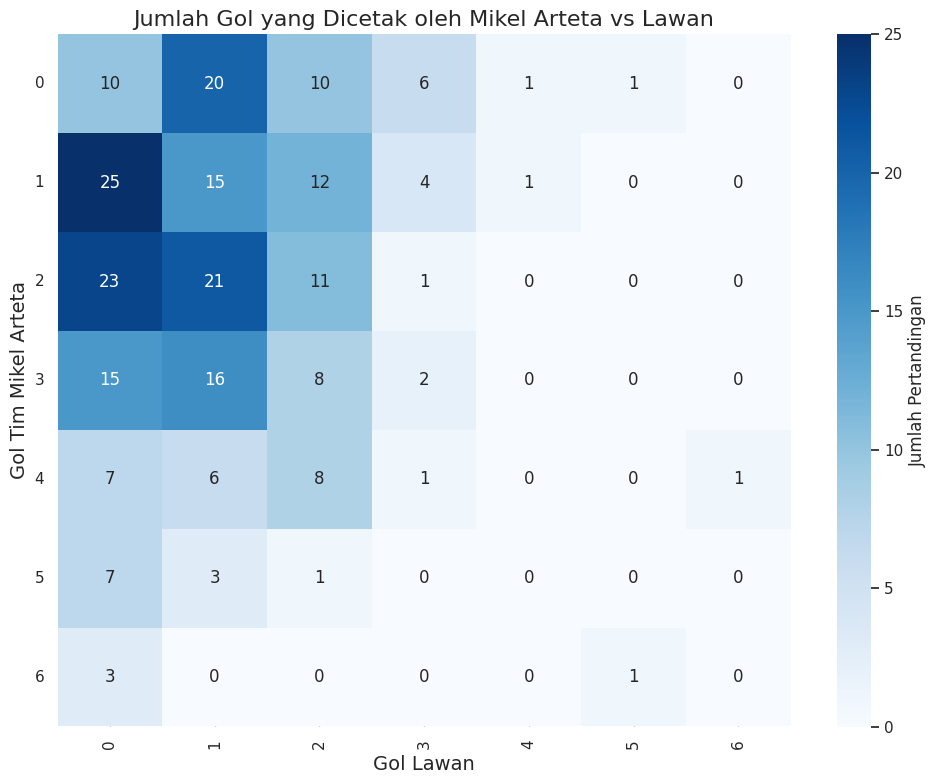

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataVisualization").getOrCreate()

# Cleaning data (ganti NaN dengan 0)
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})
df = df.withColumn("own_goals", col("own_goals").cast("integer")) \
       .withColumn("own_position", col("own_position").cast("integer")) \
       .withColumn("opponent_goals", col("opponent_goals").cast("integer")) \
       .withColumn("opponent_position", col("opponent_position").cast("integer"))

# Filter data untuk manajer Mikel Arteta
df_arteta = df.filter(df["own_manager_name"] == "Mikel Arteta")

# Convert ke Pandas untuk visualisasi
df_arteta_pd = df_arteta.toPandas()

# Hitung jumlah gol yang dicetak oleh Mikel Arteta dan tim lawannya
# Membuat DataFrame dengan jumlah gol
goals_data = df_arteta_pd[['own_goals', 'opponent_goals']]

# Membuat Pivot Table untuk Heatmap
# Kita akan menggunakan `own_goals` sebagai index dan `opponent_goals` sebagai columns
pivot_table = goals_data.pivot_table(index='own_goals', columns='opponent_goals', aggfunc='size', fill_value=0)

# Visualisasi menggunakan Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="Blues", fmt="g", cbar_kws={'label': 'Jumlah Pertandingan'})

# Menambahkan judul dan label
plt.title("Jumlah Gol yang Dicetak oleh Mikel Arteta vs Lawan", fontsize=16)
plt.xlabel("Gol Lawan", fontsize=14)
plt.ylabel("Gol Tim Mikel Arteta", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Tampilkan grafik
plt.show()


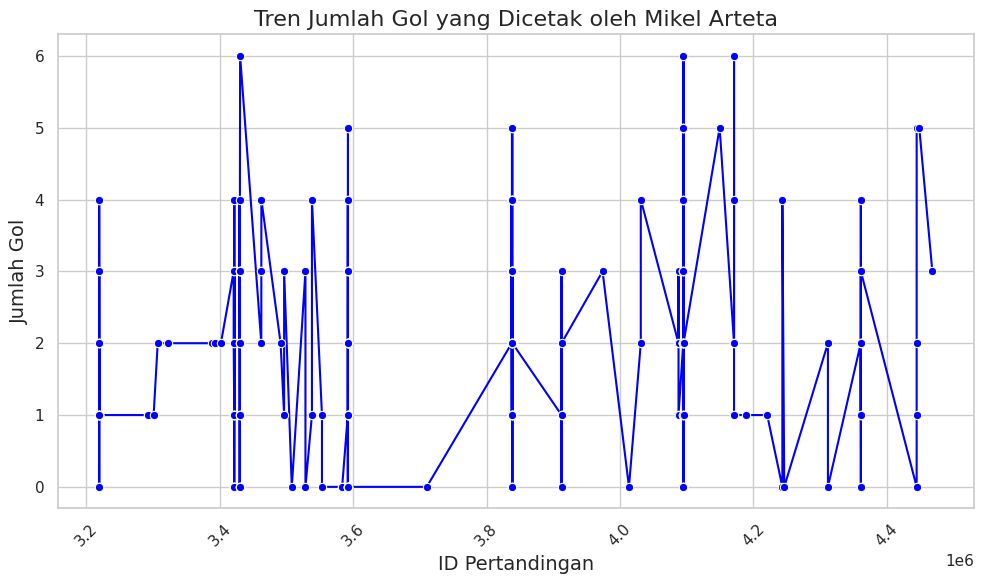

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataVisualization").getOrCreate()


# Cleaning data (ganti NaN dengan 0)
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})
df = df.withColumn("own_goals", col("own_goals").cast("integer")) \
       .withColumn("own_position", col("own_position").cast("integer")) \
       .withColumn("opponent_goals", col("opponent_goals").cast("integer")) \
       .withColumn("opponent_position", col("opponent_position").cast("integer"))

# Filter data untuk manajer Mikel Arteta
df_arteta = df.filter(df["own_manager_name"] == "Mikel Arteta")

# Convert ke Pandas untuk visualisasi
df_arteta_pd = df_arteta.toPandas()

# Pastikan kolom game_id (atau match_date) tersedia untuk digunakan sebagai sumbu-X
# Jika ada kolom tanggal, gunakan kolom tersebut. Jika tidak, kita dapat menggunakan game_id.

# Misalkan kita menggunakan game_id untuk menunjukkan urutan pertandingan
# Untuk membuat tren, kita akan mengurutkan data berdasarkan game_id
df_arteta_pd = df_arteta_pd.sort_values(by='game_id')

# Visualisasi menggunakan Line Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_arteta_pd, x='game_id', y='own_goals', marker='o', color='blue')

# Menambahkan judul dan label
plt.title("Tren Jumlah Gol yang Dicetak oleh Mikel Arteta", fontsize=16)
plt.xlabel("ID Pertandingan", fontsize=14)
plt.ylabel("Jumlah Gol", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Tampilkan grafik
plt.show()


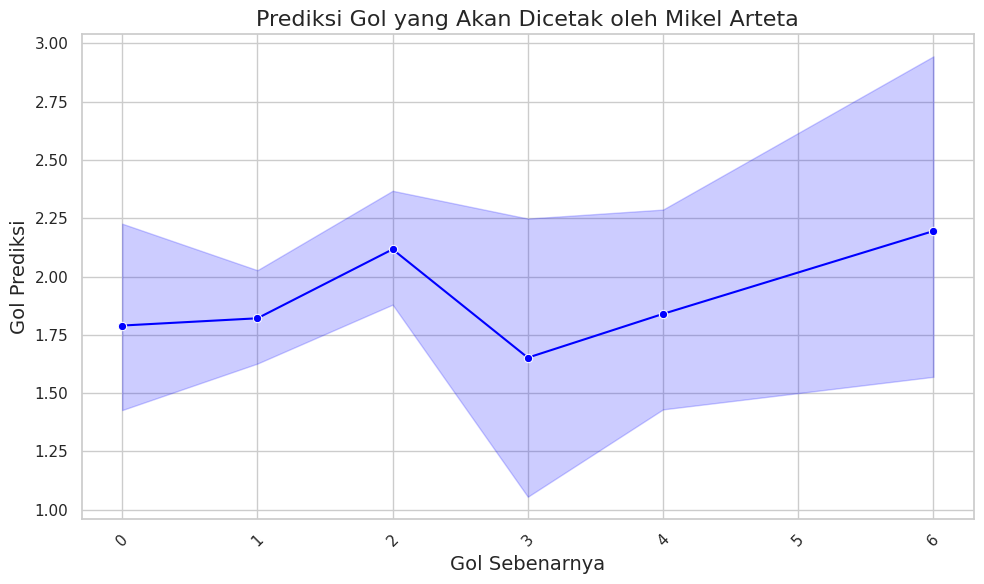

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("PredictionModel").getOrCreate()



# Cleaning data (ganti NaN dengan 0)
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})
df = df.withColumn("own_goals", col("own_goals").cast("integer")) \
       .withColumn("own_position", col("own_position").cast("integer")) \
       .withColumn("opponent_goals", col("opponent_goals").cast("integer")) \
       .withColumn("opponent_position", col("opponent_position").cast("integer"))

# Filter data untuk manajer Mikel Arteta
df_arteta = df.filter(df["own_manager_name"] == "Mikel Arteta")

# Menggunakan VectorAssembler untuk menyiapkan fitur untuk model
from pyspark.ml.feature import VectorAssembler

# Menentukan fitur yang akan digunakan untuk prediksi
assembler = VectorAssembler(inputCols=["own_position", "opponent_position", "opponent_goals"], outputCol="features")
df_arteta = assembler.transform(df_arteta)

# Memilih kolom yang dibutuhkan untuk regresi linier
df_arteta = df_arteta.select("features", "own_goals")

# Split data menjadi training dan testing
train_df, test_df = df_arteta.randomSplit([0.8, 0.2], seed=123)

# Bangun model regresi linier
lr = LinearRegression(featuresCol="features", labelCol="own_goals")
lr_model = lr.fit(train_df)

# Prediksi menggunakan model yang sudah dilatih
predictions = lr_model.transform(test_df)

# Ambil prediksi dan label asli untuk visualisasi
predicted_data = predictions.select("own_goals", "prediction").toPandas()

# Visualisasi menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=predicted_data, x="own_goals", y="prediction", marker='o', color='blue')

# Menambahkan judul dan label
plt.title("Prediksi Gol yang Akan Dicetak oleh Mikel Arteta", fontsize=16)
plt.xlabel("Gol Sebenarnya", fontsize=14)
plt.ylabel("Gol Prediksi", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Tampilkan grafik
plt.show()
